# Logistic Regression Model


In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


Utilizaremos el dataset de cáncer de mama (breast cancer)

In [2]:
data = load_breast_cancer()

In [3]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [4]:
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [5]:
# Pasamos a un Data frame
df = pd.DataFrame(data.data, columns=data.feature_names)
# Añadimos una columna con la variable objetivo
df['target'] = data.target
# Mostramos las primeras filas
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Vemos como todas las variables de entradas son `float64`. Además, no faltan valores, todas las columnas tienen 569 valores.

In [7]:
# Número de muestras por clase
# ==============================================================================
df.target.value_counts().sort_index()

0    212
1    357
Name: target, dtype: int64

Tenemos 212 muestras que no tienen cáncer y 357 que sí tienen cáncer. Aunque están un poco desbalanceadas las clases, lo vamos a dejar así.

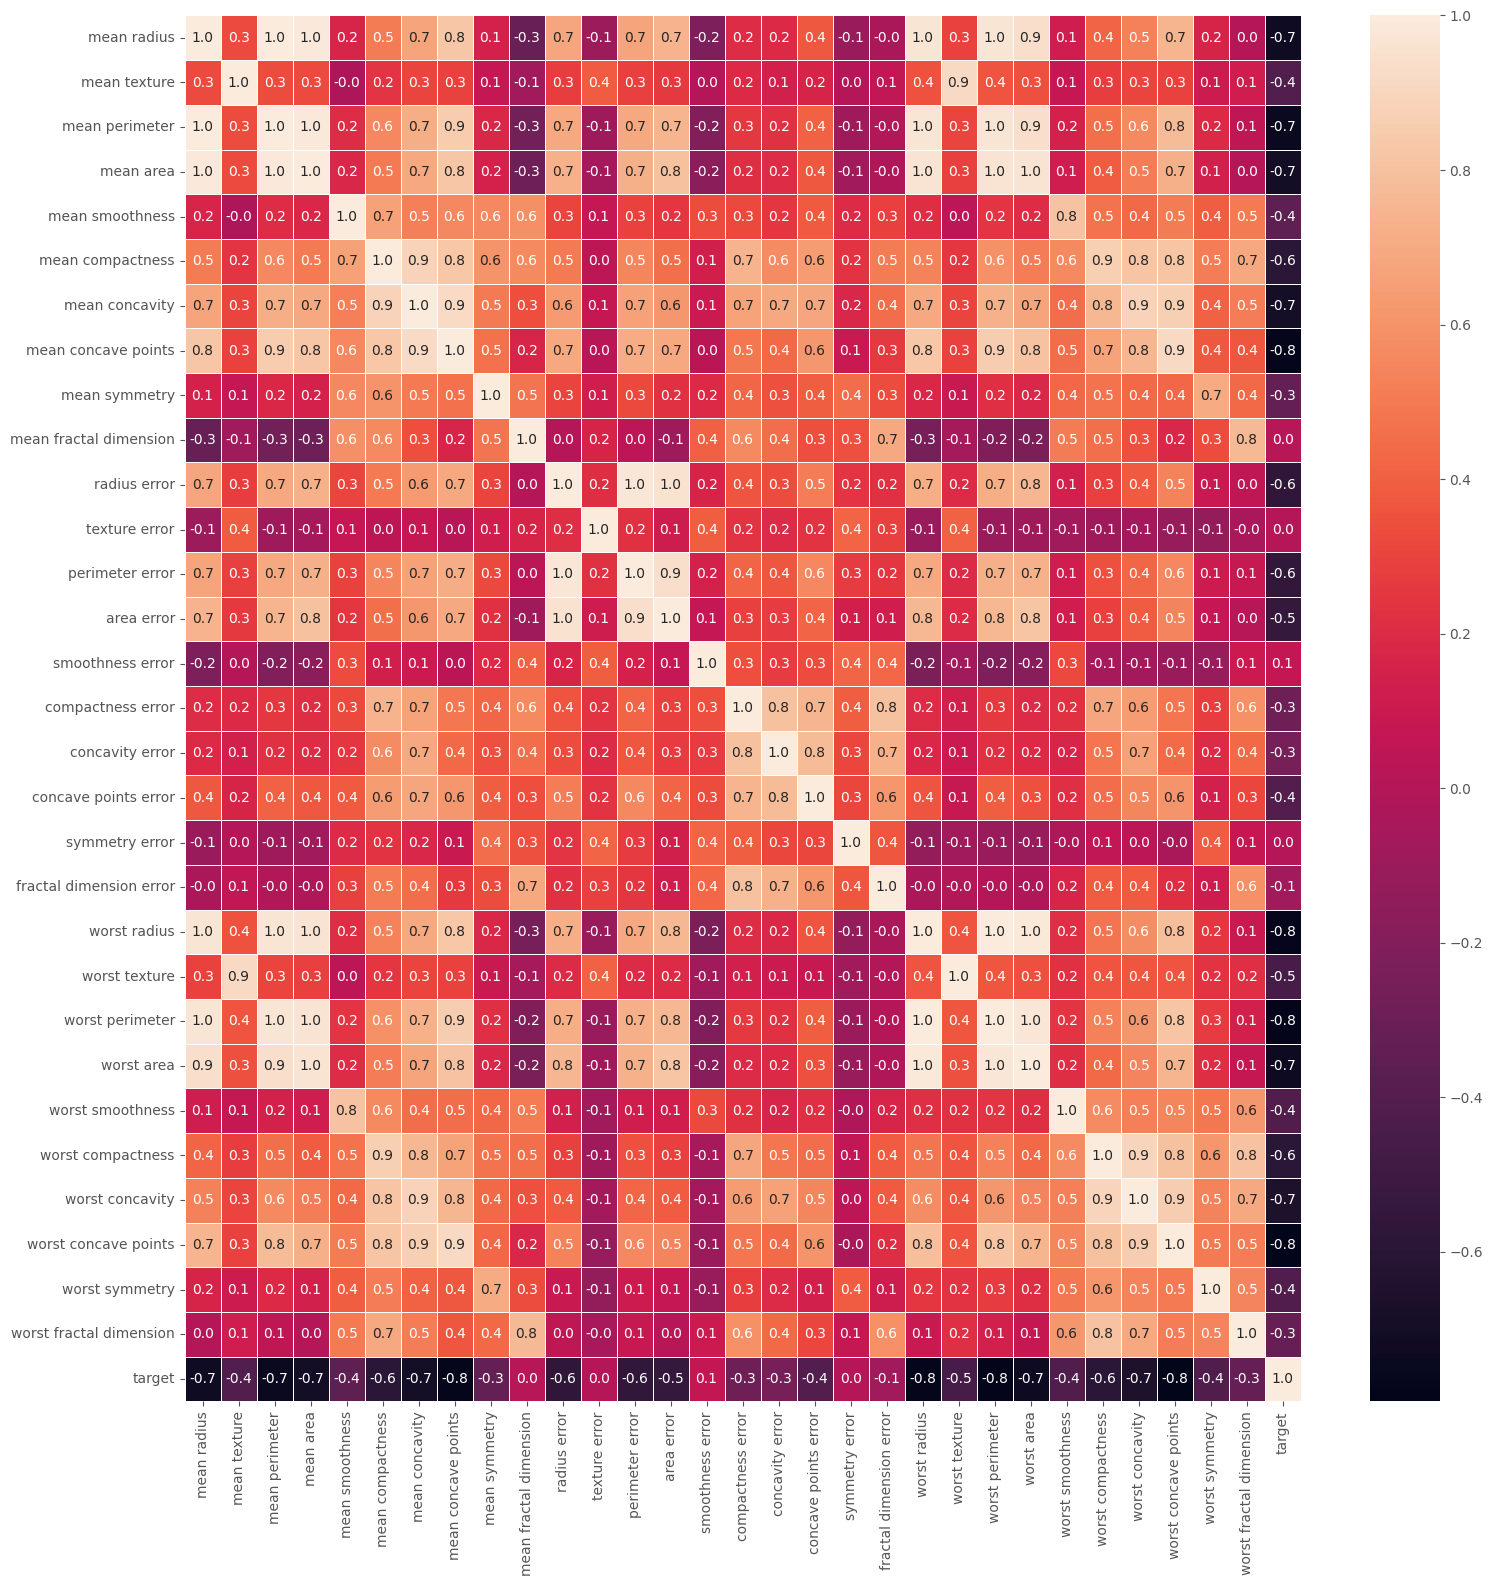

In [8]:
corr_Matrix = df.corr ()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap (corr_Matrix, linewidths = 0.5, annot = True, fmt= '.1f',ax=ax)
plt.show ()

De la matriz de correlación vemos que las variables "_mean" y "_worst" se encuentran fuertemente correladas con la variable "target" y, además, también se encuentra fuertemente correladas entre ellas ("mean radius" tiene una correlación de 1.0 con "worst radio"). Por lo tanto, nos vamos a quedar con las variables "mean" que tengan al menos una correlación superior a 0.4 con la variable de salida ("target")

In [9]:
label = []
for i in range (30):
    if np.abs(corr_Matrix.target[i]) < 0.4 or i>=10 :
        label.append (df.columns.values[i])
df.drop (labels = label, axis = 1, inplace = True)
df.head ()

,mean radius,mean texture,mean perimeter,mean area,mean compactness,mean concavity,mean concave points,target
0,17.99,10.38,122.80,1001.0,0.27760,0.3001,0.14710,0
1,20.57,17.77,132.90,1326.0,0.07864,0.0869,0.07017,0
2,19.69,21.25,130.00,1203.0,0.15990,0.1974,0.12790,0
3,11.42,20.38,77.58,386.1,0.28390,0.2414,0.10520,0
4,20.29,14.34,135.10,1297.0,0.13280,0.1980,0.10430,0


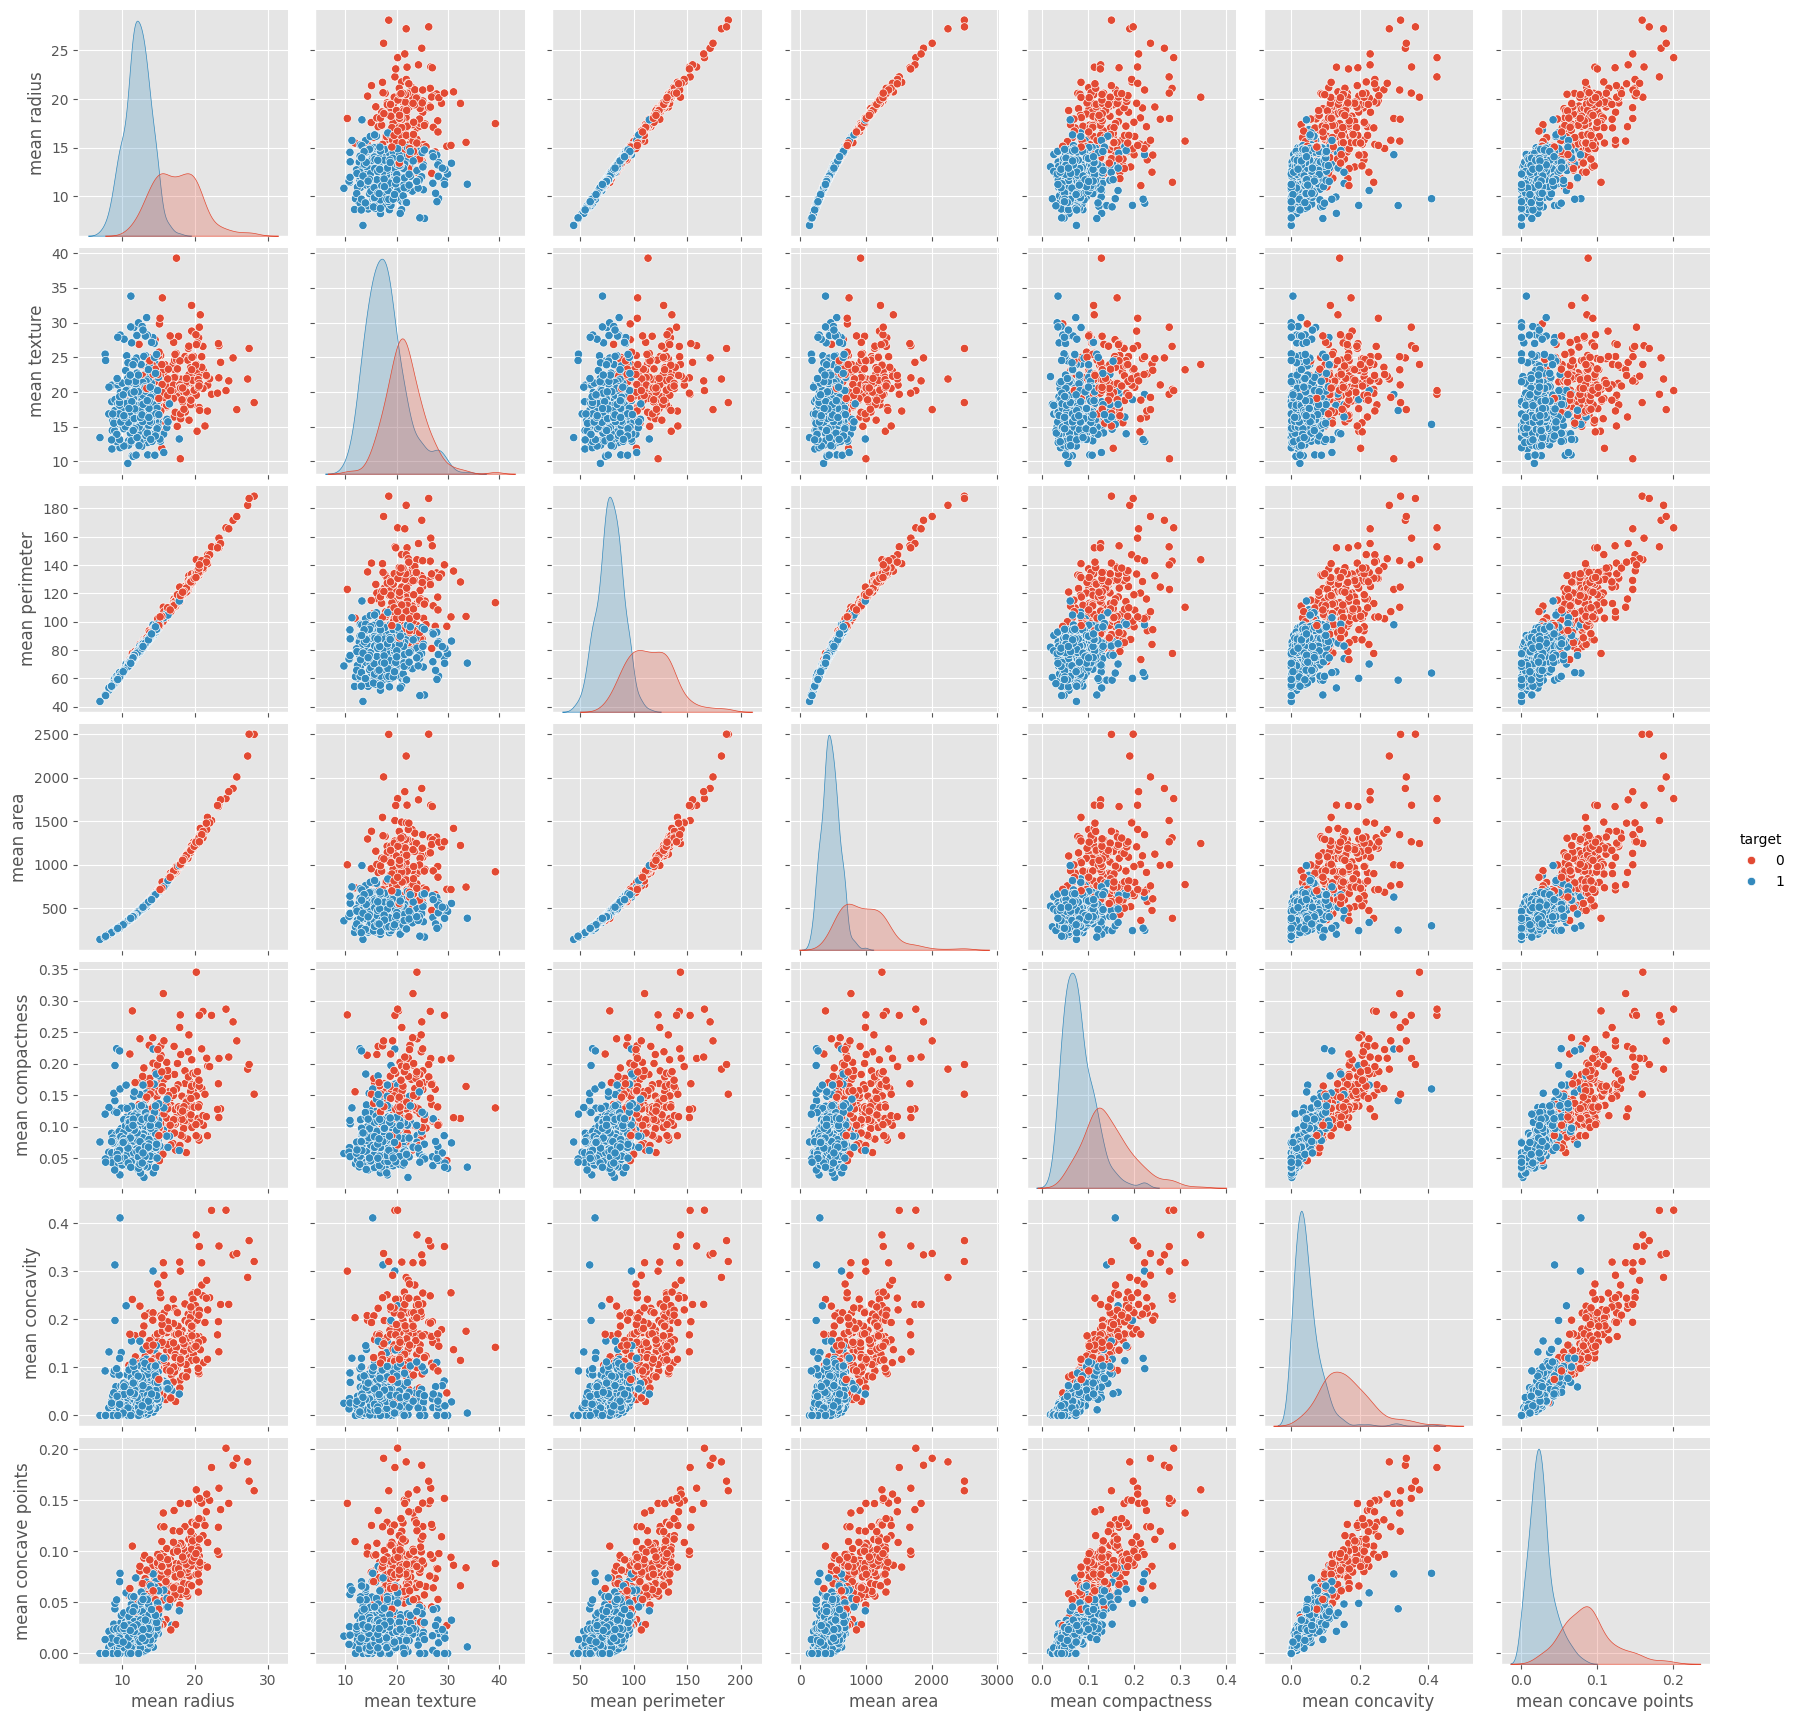

In [10]:
sns.pairplot(df, hue = "target")
plt.show()

In [11]:
# Pasamos de dataframe a numpy para poder trabajar con sklearn
X = df.iloc [:, 0:6].values
y = df.iloc [:, 7].values
# dividimos las muestras en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42, shuffle = True)

## LogisticRegression
Los parámetros más importantes de la implantación de sklearn (`LogisticRegression`) son:

- `penalty`: El tipo de aplicación de regularización. Sus valores pueden ser:{None, 'l2' (por defecto), 'l1', 'elascticnet'}
- `C`: (por defecto 1.0) Inverso de la fuerza de regularización; Valores más pequeños especifican una regularización más fuerte.
- `solver`: Algoritmo a utilizar en el problema de optimización. Sus valores pueden ser: {‘lbfgs’ (por defecto), ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}. Algunas consideraciones:

In [13]:
# Probamos el modelo sin aplicar ninguna regularización y con los parámetros por efecto
# ==============================================================================
scaler = StandardScaler()
lr = LogisticRegression(penalty='none', random_state = 42)

pipe_scale_lr = Pipeline([
    ('scale', scaler),
    ('lr', lr)])

# Entrenamiento del modelo
# ==============================================================================
cv = KFold(n_splits=5, shuffle=True, random_state = 42 )
scores = cross_val_score(pipe_scale_lr, X_train, y_train, scoring='accuracy', cv = cv) #OJO!!! scoring=‘balanced_accuracy’
                                                                                       # ¿Qué diferencia cv=5?
print(f"All the accuracies are: {scores}")
print(f"And the average crossvalidation accuracy is: {scores.mean():.2f} +- {scores.std():.2f}")


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\189lu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\189lu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\189lu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Users\189lu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "C:\Users\189lu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\189lu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'elasticnet', 'l2', 'l1'} or None. Got 'none' instead.


Ahora procedemos a la búsqueda de los hiperparámteros

In [ ]:
param_grid = [{'lr__penalty': ['l1', 'l2', 'elascticnet'],
               'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]


inner = KFold(n_splits=3, shuffle=True, random_state=42)

#budget = 40
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf = GridSearchCV (estimator  = pipe_scale_lr,
                    param_grid = param_grid,
                    scoring='accuracy', #OJO!!! scoring=‘balanced_accuracy’
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(42)

clf.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(penalty='none',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'lr__penalty': ['l1', 'l2', 'elascticnet'],
                          'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga']}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
resultados = pd.DataFrame(clf.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_lr__C,param_lr__penalty,param_lr__solver,mean_test_score,std_test_score,mean_train_score,std_train_score
36,0.1,l2,lbfgs,0.913386,0.01701,0.919948,0.010333
32,0.1,l1,liblinear,0.913386,0.02318,0.918635,0.016496
38,0.1,l2,sag,0.913386,0.01701,0.919948,0.010333
35,0.1,l2,newton-cg,0.913386,0.01701,0.919948,0.010333
39,0.1,l2,saga,0.913386,0.01701,0.919948,0.010333


In [ ]:
clf.best_params_, clf.best_score_

({'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'},
 0.9133858267716536)

Al poner el parámetro `refit=True` se reentrena el modelo indicando los valores óptimos en sus argumentos. Este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.

In [ ]:
# Información del modelo
# ==============================================================================
modelo_final = clf.best_estimator_
print("Intercept:", modelo_final['lr'].intercept_)
print("Coeficientes:", list(zip(df.columns, modelo_final['lr'].coef_.flatten(), )))
print("Accuracy de test:", modelo_final.score(X_test, y_test))

Intercept: [0.26196575]
Coeficientes: [('mean radius', 0.0), ('mean texture', -0.478653909163713), ('mean perimeter', -1.9290973323248102), ('mean area', 0.0), ('mean compactness', -0.05303948146292319), ('mean concavity', -1.220350779777424)]
Accuracy de test: 0.9468085106382979


In [ ]:
y_test_pred = modelo_final.predict(X_test)
result = metrics.classification_report(y_test, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        67
           1       0.96      0.96      0.96       121

    accuracy                           0.95       188
   macro avg       0.94      0.94      0.94       188
weighted avg       0.95      0.95      0.95       188



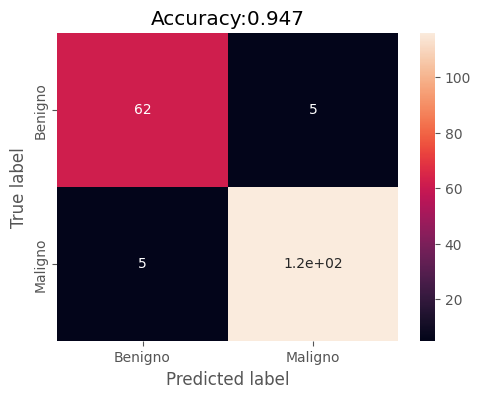

In [ ]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_pred)
accuracy = metrics.accuracy_score(y_test, y_test_pred)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Benigno','Maligno'],
                     columns = ['Benigno','Maligno'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy:{0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

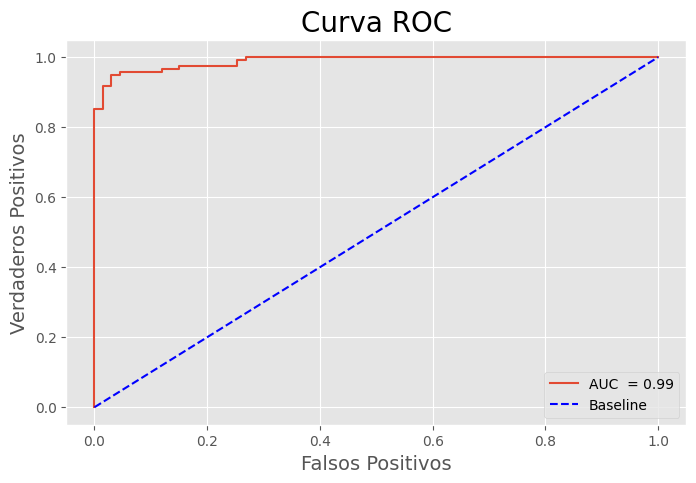

In [ ]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = modelo_final.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend();

In [ ]:
# Entrenamos con todos los datos para el modelo final
_ = modelo_final.fit(X,y)

# Selección de características mediante métododos de filtrado

## Basados en la varianza

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01) # Umbral de varianza

# Dividimos los df de las variables de entrada y la variable objetivo
df_t = df['target']
df_f = df.drop('target',axis=1)

sel = selector.fit(df_f)
sel_index = sel.get_support()
df_vt = df_f.iloc[:, sel_index]
print(df_vt.columns)

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area'], dtype='object')


## Mutual info
Calcula el valor de información mutua de cada una de las variables independientes con respecto a la variable dependiente y selecciona las que tienen mayor ganancia de información (al estilo de la ganancia de información de los árboles de decisión). En otras palabras, básicamente mide la dependencia de las características con el valor objetivo. Cuanto mayor sea la puntuación, mayor será la dependencia.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

threshold = 4  # the number of most relevant features
high_score_features = []
feature_scores = mutual_info_classif(df_f, df_t, random_state=42)
for score, f_name in sorted(zip(feature_scores, df_f.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features.append(f_name)
df_mic = df_f[high_score_features]
print(df_mic.columns)

mean concave points 0.4398738300406748
mean perimeter 0.4040339995782538
mean concavity 0.3748975259062739
mean radius 0.36509236694695946
Index(['mean concave points', 'mean perimeter', 'mean concavity',
       'mean radius'],
      dtype='object')


También podemos seleccionar, por ejemplo, aquellas variable cuya IM sea mayor que un valor (por ejemplo 0.2). Además, como ejemplo, voy a buscar el mejor clasificador usando sólo las variables seleccionadas. Esto mismo lo podemos hacer con el resto de métodos Filter.

In [ ]:
mi_score_selected_index = np.where(feature_scores >0.2)[0]
df_mic2 = df.iloc[:,mi_score_selected_index]
X_train2,X_test2,y_train,y_test = train_test_split(df_mic2,df_t,test_size=0.33,
                                                     random_state=42,
                                                     shuffle = True)
# Recordar que "clf" hace una búsqueda para los mejores parámetros
np.random.seed(42)
clf.fit(X=X_train2, y=y_train)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(penalty='none',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'lr__penalty': ['l1', 'l2', 'elascticnet'],
                          'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga']}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
clf.best_params_, clf.best_score_

({'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'},
 0.926509186351706)

In [ ]:
y_test_pred = clf.predict(X_test2)
result = metrics.classification_report(y_test, y_test_pred)
print("Classification Report with filtered features:",)
print (result)

Classification Report with filtered features:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        67
           1       0.93      0.92      0.92       121

    accuracy                           0.90       188
   macro avg       0.89      0.89      0.89       188
weighted avg       0.90      0.90      0.90       188



## F_classif
Utiliza el test f de ANOVA para las características y sólo tiene en cuenta la dependencia lineal, a diferencia de la selección de características basada en la información mutua, que puede capturar cualquier tipo de dependencia estadística. Observar que las puntuaciones obtenidas por los distintos métodos son totalmente diferentes. No os quedeis en este punto, cada método ordena internamente la importancia de las características y devuelve las mejores.


In [ ]:
from sklearn.feature_selection import f_classif
threshold = 4 # the number of most relevant features

high_score_features = []
feature_scores = f_classif(df_f, df_t)[0]
for score, f_name in sorted(zip(feature_scores, df_f.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features.append(f_name)
df_fc = df_f[high_score_features]
print(df_fc.columns)

mean concave points 861.6760200073135
mean perimeter 697.235272476532
mean radius 646.9810209786473
mean area 573.0607465682366
Index(['mean concave points', 'mean perimeter', 'mean radius', 'mean area'], dtype='object')


## Chi2
Esta clase es en realidad un enfoque más general en comparación con las clases antes mencionadas, ya que toma un parámetro adicional de función de puntuación que establece qué función utilizar en la selección de características. Por lo tanto, se puede considerar como una especie de envoltorio. También podemos utilizar f_classif o mutual_info_class_if dentro de este objeto. Por otra parte, se utiliza típicamente con la función chi2. Este objeto devuelve también los p-values de cada característica según la función de puntuación elegida.

El test chi2 mide la dependencia entre variables estocásticas, por lo que podemos eliminar las características que tienen más probabilidades de ser independientes del objetivo utilizando esta función. Sirve básicamente para evaluar si la diferencia entre dos grupos separados de muestras no negativas se debe al azar o no.

El test chi2 parte de la hipótesis nula de que dos variables son independientes y de la hipótesis alternativa de que dos variables son dependientes, como la mayoría de las pruebas estadísticas. Mediante el test chi2, se calculan los p-values de cada característica en relación con el objetivo. De forma sencilla, p es la probabilidad de que dos variables sean independientes. Lo que se busca es determinar si las características que dependen del objetivo, es decir, rechazan la hipótesis nula. Por este motivo, seleccionamos las características que suelen tener un p-value inferior a 0,05. El valor umbral de 0,05 es sólo un comportamiento común, puedes establecer valores umbral más pequeños como 0,01 para estar más seguro de que dos grupos son dependientes.


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
threshold = 4  # the number of most relevant features

skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(df_f, df_t)
sel_skb_index = sel_skb.get_support()
df_skb = df_f.iloc[:, sel_skb_index]
print('p_values', sel_skb.pvalues_)
print(df_skb.columns)

p_values [8.01397628e-60 3.32292194e-22 0.00000000e+00 0.00000000e+00
 2.01012999e-02 9.00175712e-06 1.16563638e-03]
Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area'], dtype='object')
